In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [ ]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [ ]:
data = pd.read_csv('GOOGL_20y_Final_Data_v3.csv', index_col='Date')
data = data.drop(data.columns[data.columns.str.contains('Unnamed: 0', case=False)], axis=1)
data

,Close,pct_change,log_change,Price,High,Low,Open,williams_r,cci,roc,...,lower_band,ema,momentum,fourier_3,fourier_6,fourier_9,fourier_27,fourier_81,fourier_100,arima_pred
Date,,,,,,,,,,,,,,,,,,,,,
2005-06-20,7.156032,0.009142,0.009101,7.131903,6.759511,6.867970,840147012,-17.367850,78.873663,2.826148,...,7.160677,7.156032,6.156032,85.787221,96.437706,91.413979,84.811759,88.744291,88.864397,62.663655
2005-06-21,7.221455,0.009142,0.009101,7.160260,7.088866,7.165982,604686708,-17.367850,78.873663,2.826148,...,7.160677,7.205099,6.221455,85.632584,96.086103,90.779104,82.983296,83.440451,82.318455,62.663655
2005-06-22,7.271704,0.006958,0.006934,7.196579,7.180908,7.205783,418541040,-17.367850,78.873663,2.826148,...,7.160677,7.251210,6.271704,85.477867,95.734017,90.144344,81.159640,78.150293,75.801598,62.663655
2005-06-23,7.333646,0.008518,0.008482,7.206779,7.126928,7.164241,561693744,-17.367850,78.873663,2.826148,...,7.160677,7.306854,6.333646,85.323070,95.381455,89.509730,79.341496,72.893028,69.348796,62.663655
2005-06-24,7.412999,0.010820,0.010762,7.394343,7.203545,7.236381,710137152,-17.367850,78.873663,2.826148,...,7.160677,7.377910,6.412999,85.168194,95.028426,88.875294,77.529566,67.687584,62.994321,62.663655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-12,176.720001,-0.020236,-0.020444,175.699997,174.750000,176.179993,20941900,-0.293771,103.258825,2.173553,...,163.428982,177.802211,175.720001,86.559161,98.188186,94.588954,94.001190,114.791864,120.798643,179.844426
2025-06-13,177.130005,0.002320,0.002317,174.669998,172.389999,172.440002,27663100,3.721302,60.421272,1.183564,...,164.236585,177.354074,176.130005,86.404941,97.839122,93.953985,92.159412,109.709158,114.633414,176.076923
2025-06-16,176.940002,-0.001073,-0.001073,176.770004,174.649994,174.729996,27389200,1.860651,79.779018,1.567604,...,164.787954,177.078026,175.940002,86.250637,97.489534,93.318971,90.318860,104.544100,108.323384,176.943835


In [ ]:
df = data['Close']
data.pop('Close')
data['Close'] = df

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Add target variable
data['y'] = data['Close']

# Clean the data before splitting
print("=== Data Cleaning ===")
print(f"Original data shape: {data.shape}")

# Check for problematic values
print(f"NaN values: {data.isnull().sum().sum()}")
print(f"Infinite values: {np.isinf(data.select_dtypes(include=[np.number])).sum().sum()}")

# Clean infinite values and NaN
# Replace infinite values with NaN first
data = data.replace([np.inf, -np.inf], np.nan)

# Forward fill NaN values, then backward fill any remaining
data = data.fillna(method='ffill').fillna(method='bfill')

# If there are still NaN values (e.g., first few rows), fill with 0
data = data.fillna(0)

# Cap extremely large values
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].clip(lower=-1e6, upper=1e6)

# Verify cleaning
print(f"After cleaning - NaN values: {data.isnull().sum().sum()}")
print(f"After cleaning - Infinite values: {np.isinf(data.select_dtypes(include=[np.number])).sum().sum()}")

# Extract features and target
x = data.iloc[:, :62].values  # First 62 columns as features
y = data.iloc[:, 62].values   # 63rd column (index 62) as target

print(f"Feature matrix shape: {x.shape}")
print(f"Target vector shape: {y.shape}")

# Train-test split
split = int(data.shape[0] * 0.7)
train_x, test_x = x[:split, :], x[split - 20:, :]
train_y, test_y = y[:split], y[split - 20:]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

# Final check before scaling
print("\n=== Pre-scaling Check ===")
print(f"Train X - Min: {np.min(train_x)}, Max: {np.max(train_x)}")
print(f"Test X - Min: {np.min(test_x)}, Max: {np.max(test_x)}")
print(f"Train X - NaN: {np.sum(np.isnan(train_x))}, Inf: {np.sum(np.isinf(train_x))}")
print(f"Test X - NaN: {np.sum(np.isnan(test_x))}, Inf: {np.sum(np.isinf(test_x))}")

# Scale the data
try:
    x_scaler = MinMaxScaler(feature_range=(0, 1))
    y_scaler = MinMaxScaler(feature_range=(0, 1))

    train_x_scaled = x_scaler.fit_transform(train_x)
    test_x_scaled = x_scaler.transform(test_x)

    train_y_scaled = y_scaler.fit_transform(train_y.reshape(-1, 1))
    test_y_scaled = y_scaler.transform(test_y.reshape(-1, 1))

    print("\n=== Scaling Successful! ===")
    print(f"Scaled trainX: {train_x_scaled.shape}")
    print(f"Scaled testX: {test_x_scaled.shape}")
    print(f"Scaled trainY: {train_y_scaled.shape}")
    print(f"Scaled testY: {test_y_scaled.shape}")

    # Update variables
    train_x = train_x_scaled
    test_x = test_x_scaled
    train_y = train_y_scaled
    test_y = test_y_scaled

except Exception as e:
    print(f"\nScaling failed: {e}")
    print("Trying alternative approach...")

    # Alternative: Use robust preprocessing
    from sklearn.preprocessing import RobustScaler

    # Use RobustScaler for features (more robust to outliers)
    x_scaler = RobustScaler()
    y_scaler = MinMaxScaler(feature_range=(0, 1))

    train_x_scaled = x_scaler.fit_transform(train_x)
    test_x_scaled = x_scaler.transform(test_x)

    train_y_scaled = y_scaler.fit_transform(train_y.reshape(-1, 1))
    test_y_scaled = y_scaler.transform(test_y.reshape(-1, 1))

    print("Alternative scaling successful!")

    # Update variables
    train_x = train_x_scaled
    test_x = test_x_scaled
    train_y = train_y_scaled
    test_y = test_y_scaled

=== Data Cleaning ===
Original data shape: (5032, 63)
NaN values: 0
Infinite values: 160
After cleaning - NaN values: 0
After cleaning - Infinite values: 0
Feature matrix shape: (5032, 62)
Target vector shape: (5032,)
trainX: (3522, 62) trainY: (3522,)
testX: (1530, 62) testY: (1530,)

=== Pre-scaling Check ===
Train X - Min: -1000000.0, Max: 1000000.0
Test X - Min: -1000000.0, Max: 1000000.0
Train X - NaN: 0, Inf: 0
Test X - NaN: 0, Inf: 0

=== Scaling Successful! ===
Scaled trainX: (3522, 62)
Scaled testX: (1530, 62)
Scaled trainY: (3522, 1)
Scaled testY: (1530, 1)


In [ ]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        # Encoder
        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        # Decoder
        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])
        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        )
        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logVar = self.fc_var(encoded)
        return mu, logVar

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, logVar, deterministic=True):
        if deterministic or not self.training:
            return mu
        std = torch.exp(0.5 * logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x, deterministic=False):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar, deterministic=deterministic)
        reconstructed = self.decode(z)
        return reconstructed, z, mu, logVar

In [ ]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([62, 400, 400, 400, 10], 10)

[1/300] Loss: 0.104280, Recon: 0.125800, KL: 0.194307
[2/300] Loss: 0.101826, Recon: 0.125743, KL: 0.186823
[3/300] Loss: 0.097400, Recon: 0.127787, KL: 0.182315
[4/300] Loss: 0.089621, Recon: 0.133204, KL: 0.178554
[5/300] Loss: 0.081124, Recon: 0.147340, KL: 0.176073
[6/300] Loss: 0.075689, Recon: 0.159658, KL: 0.174076
[7/300] Loss: 0.073374, Recon: 0.171788, KL: 0.170928
[8/300] Loss: 0.073410, Recon: 0.175720, KL: 0.167494
[9/300] Loss: 0.074119, Recon: 0.178737, KL: 0.163157
[10/300] Loss: 0.075105, Recon: 0.178513, KL: 0.160178
[11/300] Loss: 0.075858, Recon: 0.176125, KL: 0.155123
[12/300] Loss: 0.077045, Recon: 0.179949, KL: 0.150124
[13/300] Loss: 0.077876, Recon: 0.178165, KL: 0.145221
[14/300] Loss: 0.079032, Recon: 0.183700, KL: 0.141313
[15/300] Loss: 0.079693, Recon: 0.177877, KL: 0.137147
[16/300] Loss: 0.080576, Recon: 0.180170, KL: 0.132608
[17/300] Loss: 0.081061, Recon: 0.176382, KL: 0.128079
[18/300] Loss: 0.081610, Recon: 0.176895, KL: 0.124017
[19/300] Loss: 0.08

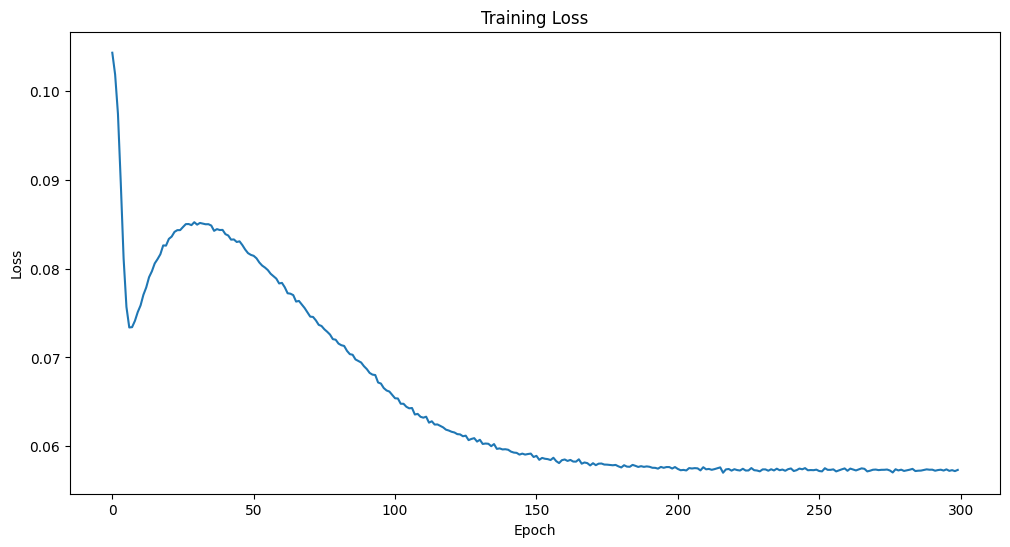

In [ ]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 300
learning_rate = 0.00003
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# KL annealing function
def kl_weight(epoch, max_epochs=300):
    return min(1.0, epoch / (max_epochs * 0.3))

hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        optimizer.zero_grad()  # Important: zero gradients before backward pass

        output, z, mu, logVar = model(x)

        # KL divergence (normalized by batch size)
        kl_divergence = -0.5 * torch.sum(1 + logVar - mu.pow(2) - logVar.exp()) / x.size(0)

        # Reconstruction loss
        reconstruction_loss = F.mse_loss(output, x)

        # Combined loss with KL annealing
        kl_weight_current = kl_weight(epoch, num_epochs)
        loss = reconstruction_loss + kl_weight_current * kl_divergence

        loss.backward()
        optimizer.step()
        loss_.append(loss.item())

    hist[epoch] = sum(loss_) / len(loss_)  # Average loss per batch
    print('[{}/{}] Loss: {:.6f}, Recon: {:.6f}, KL: {:.6f}'.format(
        epoch+1, num_epochs, hist[epoch],
        reconstruction_loss.item(), kl_divergence.item()))

plt.figure(figsize=(12, 6))
plt.plot(hist)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device), deterministic=True)
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device), deterministic=True)

In [ ]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [ ]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [ ]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([3519, 3, 72]) train_y: torch.Size([3519, 1]) train_y_gan: torch.Size([3519, 4, 1])
test_x: torch.Size([1527, 3, 72]) test_y: torch.Size([1527, 1]) test_y_gan: torch.Size([1527, 4, 1])


# GAN Model

Generator: LSTM

Discriminator: CNN

In [ ]:
class Generator(nn.Module):
    ### LSTM GENERATOR
    def __init__(self, input_size):
        super().__init__()
        # Single LSTM layer: 112 -> 500
        self.lstm = nn.LSTM(input_size, 500, batch_first=True)
        # Dense decoder: 500 -> 1 (linear)
        self.decoder = nn.Linear(500, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

        # Initialize hidden and cell states for LSTM
        h0 = torch.zeros(1, x.size(0), 500).to(device)
        c0 = torch.zeros(1, x.size(0), 500).to(device)

        # Forward through LSTM
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)

        # Take the last time step output and pass through decoder
        out = self.decoder(out[:, -1, :])

        return out

class Discriminator(nn.Module):
    def __init__(self, input_channels=4):
        super().__init__()

        # Convolutional layers with stride=2 (downsampling)
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, stride=2, padding=2)
        self.leaky1 = nn.LeakyReLU(0.01)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2)
        self.leaky2 = nn.LeakyReLU(0.01)
        self.bn1 = nn.BatchNorm1d(64)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2)
        self.leaky3 = nn.LeakyReLU(0.01)
        self.bn2 = nn.BatchNorm1d(128)

        # Global Average Pooling to handle variable sequence lengths
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(128, 220)
        self.bn3 = nn.BatchNorm1d(220)
        self.leaky4 = nn.LeakyReLU(0.01)

        self.fc2 = nn.Linear(220, 220)
        self.relu = nn.ReLU()

        self.fc3 = nn.Linear(220, 1)

    def forward(self, x):
        # Convolutional layers with downsampling
        x = self.conv1(x)
        x = self.leaky1(x)

        x = self.conv2(x)
        x = self.leaky2(x)
        x = self.bn1(x)

        x = self.conv3(x)
        x = self.leaky3(x)
        x = self.bn2(x)

        # Global pooling to get fixed-size representation
        x = self.global_pool(x)  # Shape: (batch_size, 128, 1)
        x = x.squeeze(-1)        # Shape: (batch_size, 128)

        # Fully connected layers
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.leaky4(x)

        x = self.fc2(x)
        x = self.relu(x)

        x = self.fc3(x)

        return x

In [ ]:
def compute_gradient_penalty(D, real_samples, fake_samples, device):
    alpha = torch.rand(real_samples.size(0), 1, 1, device=device)
    alpha = alpha.expand_as(real_samples)

    interpolates = alpha * real_samples + ((1 - alpha) * fake_samples)
    interpolates.requires_grad_(True)

    d_interpolates = D(interpolates)
    fake = torch.ones_like(d_interpolates, requires_grad=False).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [ ]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.00015
num_epochs = 30
critic_iterations = 5

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = True)

modelG = Generator(72).to(device)
modelD = Discriminator().to(device)

optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0
λ = 10  # Gradient penalty coefficient

for epoch in range(num_epochs):
    loss_G = []
    loss_D = []

    for i, (x, y) in enumerate(trainDataloader):
        x = x.to(device)
        y = y.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        for _ in range(critic_iterations):
            fake_data = modelG(x)
            fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis=1).detach()

            critic_real = modelD(y)
            critic_fake = modelD(fake_data)

            # Gradient penalty
            gp = compute_gradient_penalty(modelD, y, fake_data)

            lossD = -torch.mean(critic_real) + torch.mean(critic_fake) + λ * gp

            optimizerD.zero_grad()
            lossD.backward()
            optimizerD.step()

        # -----------------
        #  Train Generator
        # -----------------
        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis=1)
        output_fake = modelD(fake_data)
        lossG = -torch.mean(output_fake)

        optimizerG.zero_grad()
        lossG.backward()
        optimizerG.step()

        loss_D.append(lossD.item())
        loss_G.append(lossG.item())

    histG[epoch] = np.mean(loss_G)
    histD[epoch] = np.mean(loss_D)
    print(f"[{epoch+1}/{num_epochs}] LossD: {histD[epoch]:.4f} LossG: {histG[epoch]:.4f}")

[1/30] LossD: 3907.5926 LossG: 1.5033
[2/30] LossD: 91.3714 LossG: 2.1503
[3/30] LossD: 66.3908 LossG: 1.6071
[4/30] LossD: 53.3312 LossG: 0.3048
[5/30] LossD: 45.4708 LossG: -0.5929
[6/30] LossD: 26.9655 LossG: -0.3898
[7/30] LossD: 26.4015 LossG: 0.2435
[8/30] LossD: 24.3713 LossG: -0.0020
[9/30] LossD: 20.5684 LossG: -0.0117
[10/30] LossD: 15.0024 LossG: 0.2594
[11/30] LossD: 12.8797 LossG: 0.2005
[12/30] LossD: 10.2553 LossG: 0.3511
[13/30] LossD: 9.4082 LossG: 0.2380
[14/30] LossD: 8.5945 LossG: 0.1527
[15/30] LossD: 8.4153 LossG: 0.1611
[16/30] LossD: 7.1856 LossG: 0.5021
[17/30] LossD: 5.5484 LossG: 0.5646
[18/30] LossD: 4.7939 LossG: 0.5125
[19/30] LossD: 4.5493 LossG: 0.5053
[20/30] LossD: 4.1106 LossG: 0.6650
[21/30] LossD: 3.6496 LossG: 0.6766
[22/30] LossD: 3.4472 LossG: 0.5876
[23/30] LossD: 2.5901 LossG: 0.4796
[24/30] LossD: 2.8203 LossG: 0.4584
[25/30] LossD: 3.5633 LossG: 0.4293
[26/30] LossD: 2.9285 LossG: 0.4310
[27/30] LossD: 2.8716 LossG: 0.5264
[28/30] LossD: 2.76

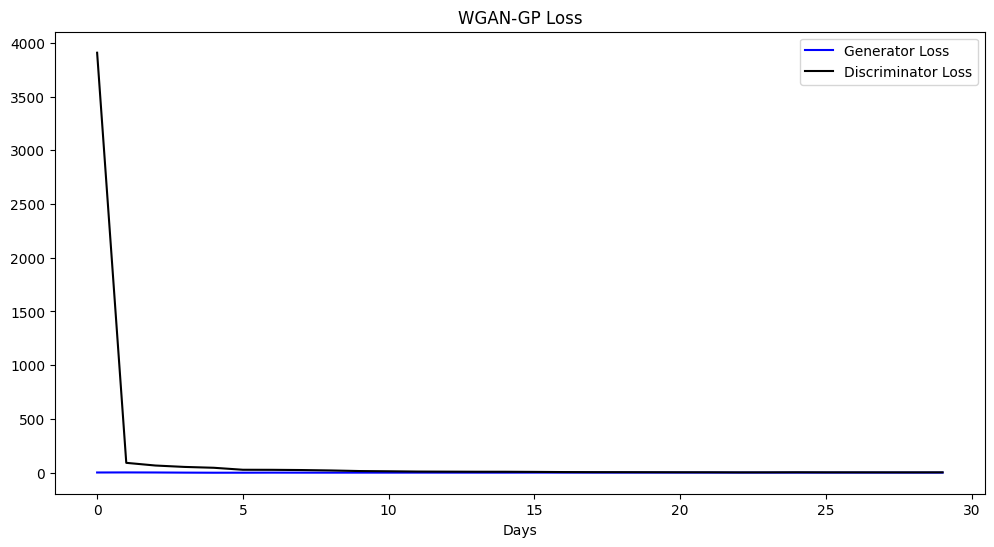

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('WGAN-GP Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

In [ ]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:2.5701205658583692


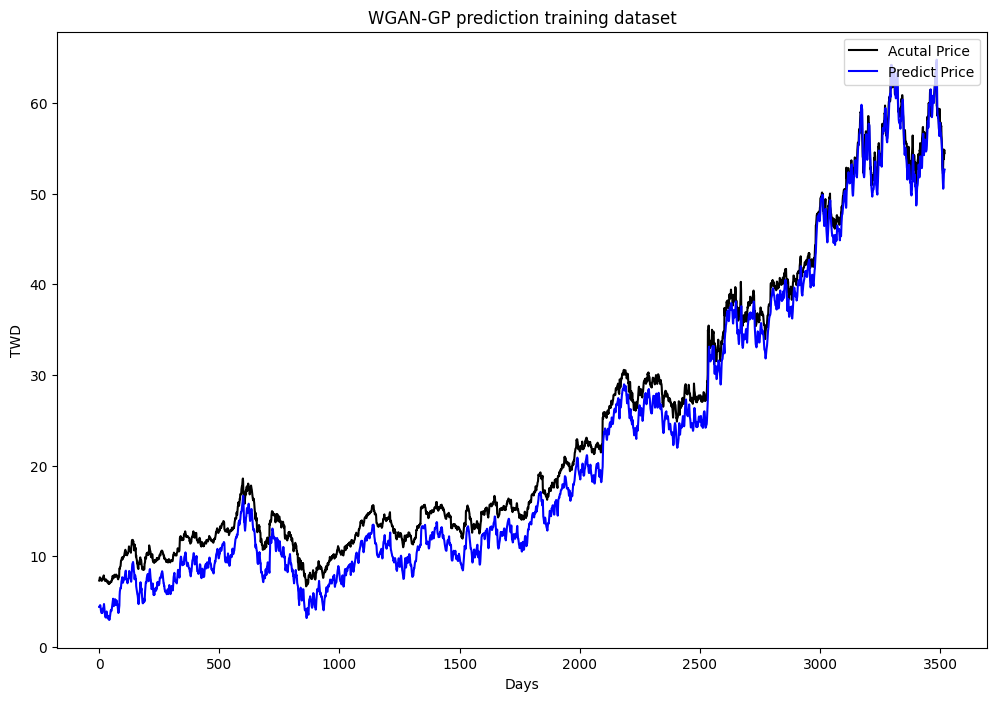

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN-GP prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Test dataset RMSE:4.398207110743013


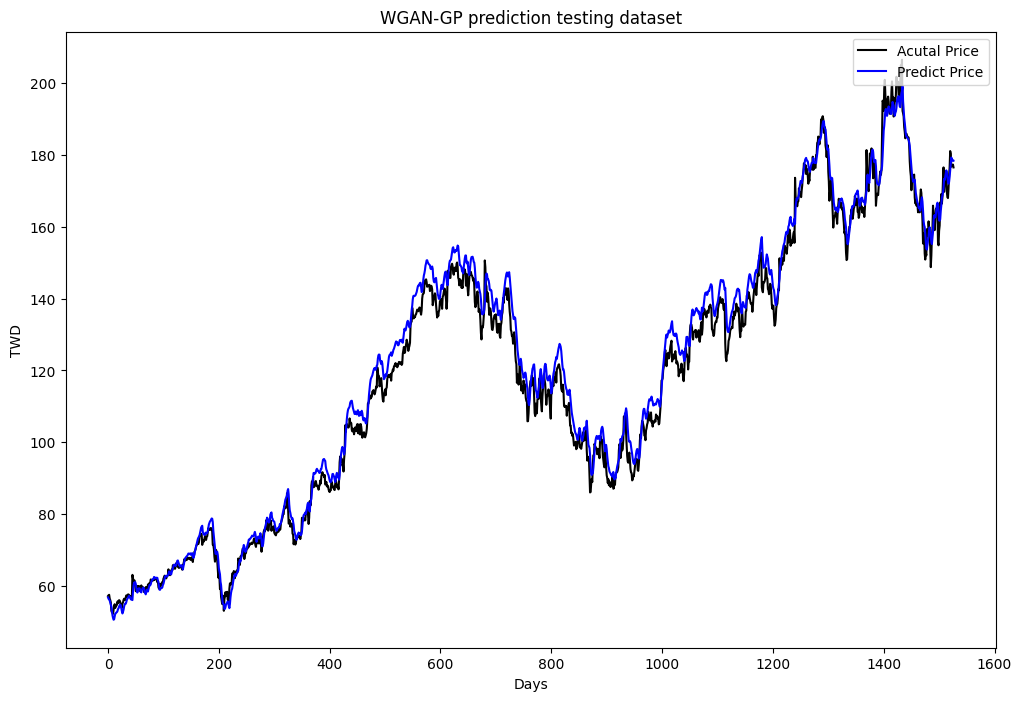

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN-GP prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Test dataset RMSE:{RMSE}')

In [ ]:
# ================================
# 🔐 SAVE VAE + WGAN MODELS (FINAL)
# ================================

import torch
import json
import joblib
import os
import zipfile

# --- CONFIG ---
vae_config = [62, 400, 400, 400, 10]
latent_dim = 10
vae_save_dir = "vae_export"
vae_zip_path = f"{vae_save_dir}.zip"
generator_save_path = "generator.pth"
discriminator_save_path = "discriminator.pth"

# --- ENSURE VAE DIR EXISTS ---
os.makedirs(vae_save_dir, exist_ok=True)

# --- SAVE VAE MODEL ---
torch.save(model.state_dict(), f"{vae_save_dir}/vae.pth")  # assumes VAE = `model`

# --- SAVE VAE CONFIG ---
with open(f"{vae_save_dir}/vae_config.json", "w") as f:
    json.dump({"config": vae_config, "latent_dim": latent_dim}, f)

# --- SAVE SCALER IF EXISTS ---
try:
    joblib.dump(y_scaler, f"{vae_save_dir}/scaler.pkl")
    print("✅ Scaler saved.")
except Exception as e:
    print("⚠️ Skipping scaler: ", e)

# --- ZIP VAE EXPORT DIR ---
with zipfile.ZipFile(vae_zip_path, 'w') as zipf:
    for fname in os.listdir(vae_save_dir):
        zipf.write(os.path.join(vae_save_dir, fname), arcname=fname)
print(f"✅ VAE model zipped and saved to: {vae_zip_path}")

# --- SAVE WGAN-GP MODELS ---
torch.save(modelG.state_dict(), generator_save_path)       # assumes generator = modelG
torch.save(modelD.state_dict(), discriminator_save_path)   # assumes discriminator = modelD
print(f"✅ Generator saved to: {generator_save_path}")
print(f"✅ Discriminator saved to: {discriminator_save_path}")

✅ Scaler saved.
✅ VAE model zipped and saved to: vae_export.zip
✅ Generator saved to: generator.pth
✅ Discriminator saved to: discriminator.pth
